# Evaluación del caso “Trío no colineal con planeta errante”

Exploramos un sistema de tres cuerpos inicialmente no colineales: dos estrellas masivas y un planeta errante que parte con desplazamiento lateral. Buscamos combinaciones de masa que reduzcan la sensibilidad caótica y mantengan la órbita del planeta dentro de un lazo estable durante integraciones largas.

> **Interpretación**
> - Un λ reducido indica que el planeta soporta mejor las perturbaciones y permanece ligado al sistema.
> - La penalización de periodicidad ayuda a mantener la topología orbital tras miles de unidades de tiempo, evitando salidas balísticas.


## Preparación del entorno

Localizamos la carpeta raíz `two_body`, la añadimos a `sys.path` y exponemos `PARENT` para reutilizar módulos comunes del repositorio. Garantizamos que los imports funcionen sin importar la ruta desde la que se ejecute el notebook.


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

if PROJECT_ROOT.name != "two_body":
    raise RuntimeError("No se encontró la carpeta two_body")

PARENT = PROJECT_ROOT.parent  # directorio que contiene a two_body
if str(PARENT) not in sys.path:
    sys.path.insert(0, str(PARENT))

print("PYTHONPATH += ", PARENT)


PYTHONPATH +=  C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies


## Dependencias principales
Importamos los componentes clave del pipeline:
- `Config` y utilidades de seeding.
- El controlador híbrido (GA + refinamiento).
- Herramientas de visualización y simulación REBOUND.
- `numpy` para cualquier análisis adicional.


In [ ]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer as PlanarVisualizer
from two_body.presentation.triDTry import Visualizer as Visualizer3D
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np
from pathlib import Path 


## Instrumentación de rendimiento

Activamos las variables de entorno de la suite de timings y cargamos `time_block`, `latest_timing_csv`, etc. Esto nos permitirá auditar qué tan costosa es cada fase (integración short/long, refinamiento continuo, métricas).


In [3]:
import os
os.environ["PERF_TIMINGS_ENABLED"] = "1"
os.environ.setdefault("PERF_TIMINGS_JSONL", "0")

from two_body.perf_timings.timers import time_block
from two_body.perf_timings import latest_timing_csv, read_timings_csv, parse_sections_arg, filter_rows


## Logging amigable para notebooks

Definimos un `NotebookHandler` que acumula los mensajes del optimizador y los muestra en vivo dentro de la celda. Mantiene la salida legible mientras corren las generaciones y el refinamiento continuo.


In [4]:

import logging
from IPython.display import display, Markdown

class NotebookHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.lines = []

    def emit(self, record):
        msg = self.format(record)
        self.lines.append(msg)
        print(msg)

handler = NotebookHandler()
handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s"))

logger = setup_logger(level="INFO")
logger.handlers.clear()
logger.addHandler(handler)
logger.setLevel(logging.INFO)


## Configuración del escenario “Trío no colineal” físico

Trabajamos con unidades astronómicas (UA, años, masas solares):
- Binaria compacta ~1.05/0.75 Msun separada 0.7 UA.
- Intruso tipo planeta/enano marrón que cruza el plano con fuerte componente tangencial.
- Presupuestos moderados del GA para barridos rápidos.


In [ ]:
# Tres cuerpos caótico (unidades físicas)
case = {
    # Integración (UA, años, masas solares)
    "t_end_short": 0.6,
    "t_end_long": 3.5,
    "dt": 2.0e-4,
    "integrator": "ias15",

    # Condiciones iniciales: binaria compacta + intruso
    "r0": (
        (-0.2916667, 0.0, 0.0),     # estrella primaria
        (0.4083333, 0.0, 0.0),      # estrella secundaria
        (0.0, 1.8, 0.0),            # intruso (planeta/brown dwarf)
    ),
    "v0": (
        (0.0, -4.19812977, 0.0),    # velocidad orbital de la primaria
        (0.0, 5.87738168, 0.0),     # velocidad orbital de la secundaria
        (-3.2, 0.0, 0.0),           # intruso con trayectoria rasante
    ),

    # Rangos de masa físicos pero amplios (fomenta caos)
    "mass_bounds": (
        (1.00, 1.50),
        (0.5, 1.0),
        (5e-5, 5e-1),
    ),
    "G": 39.47841760435743,
    "periodicity_weight": 0.02,

    # GA / búsqueda continua
    "pop_size": 180,
    "n_gen_step": 5,
    "crossover": 0.85,
    "mutation": 0.20,
    "elitism": 2,
    "seed": 98765,

    # Control de ejecución (rápido pero con margen)
    "max_epochs": 50,
    "top_k_long": 12,
    "stagnation_window": 5,
    "stagnation_tol": 1.25e-4,
    "local_radius": 0.04,
    "radius_decay": 0.85,
    "time_budget_s": 1800.0,
    "eval_budget": 16000,

    # Artefactos / salida
    "artifacts_dir": "artifacts/caso04_caotico",
    "save_plots": True,
    "headless": False,
}


In [6]:

from two_body.logic.controller import ContinuousOptimizationController
from two_body.core.config import Config
from two_body.core.telemetry import setup_logger
from two_body.core.cache import HierarchicalCache

cfg = Config(**case)
set_global_seeds(cfg.seed)
logger = setup_logger()


## Validación rápida del estimador de Lyapunov

Antes de lanzar el controlador, construimos una simulación con las masas promedio y ejecutamos `LyapunovEstimator.mLCE`. Esto sirve como smoke test para confirmar que el integrador produce trayectorias razonables y que el cálculo de λ responde al nuevo escenario.


In [7]:
from two_body.simulation.rebound_adapter import ReboundSim
from two_body.simulation.lyapunov import LyapunovEstimator

masses = tuple(np.mean(bounds) for bounds in cfg.mass_bounds)
sim = ReboundSim(G=cfg.G, integrator=cfg.integrator).setup_simulation(
    masses, cfg.r0[:len(masses)], cfg.v0[:len(masses)]
)
estimator = LyapunovEstimator()
ret = estimator.mLCE({"sim": sim, "dt": cfg.dt, "t_end": cfg.t_end_short, "masses": masses})
print(ret)


{'lambda': -2.805939681704063, 'series': None, 'meta': {'steps': 3000, 'dt': 0.0002, 'n_bodies': 3, 'masses': (1.25, 0.75, 0.250025), 'impl': 'rebound_megno'}}


c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Recarga del evaluador de fitness

Si se modificó `two_body.logic.fitness`, recargamos el módulo con `importlib.reload` y reinstanciamos `setup_logger`. Así garantizamos que el notebook utilice la versión fresca del evaluador antes de iniciar la optimización.


In [ ]:
import logging
import importlib

from two_body.core.telemetry import setup_logger
import two_body.logic.fitness as fitness_mod

logger = setup_logger(level="INFO")         # asegura nivel INFO
logger.setLevel(logging.INFO)
for handler in logger.handlers:
    handler.setLevel(logging.INFO)


## Ejecución del controlador híbrido

Instanciamos `Config`, el `logger` y `ContinuousOptimizationController`, y envolvemos `controller.run()` dentro de `time_block("notebook_run")` para medir la ejecución total (GA + refinamiento continuo) sobre el sistema no colineal.


In [9]:
print(cfg.mass_bounds, cfg.max_epochs, cfg.eval_budget)

((1.0, 1.5), (0.5, 1.0), (5e-05, 0.5)) 50 16000


In [10]:
with time_block("notebook_run", extra={"source": "Caso04.ipynb"}):
    controller = ContinuousOptimizationController(cfg, logger=logger)
    results = controller.run()

[2025-11-02 18:03:26,843] INFO - Starting optimization | pop=180 | dims=3 | time_budget=1800.0s | eval_budget=16000
[2025-11-02 18:03:42,588] INFO - Epoch 0 | new global best (short) lambda=-5.242842 | fitness=4.406297 | penalty=41.827273 | masses=(1.319555, 0.57681, 0.269317)
[2025-11-02 18:03:49,934] INFO - Epoch 0 complete | lambda_short=-5.242842 | fitness_short=4.406297 | lambda_best=-5.242842 | fitness_best=4.406297 | evals short/long=180/12 | total evals=192 | radius=0.0400
[2025-11-02 18:04:13,818] INFO - Epoch 1 complete | lambda_short=0.718596 | fitness_short=-1.309171 | lambda_best=-5.242842 | fitness_best=4.406297 | evals short/long=180/12 | total evals=384 | radius=0.0400
[2025-11-02 18:04:37,285] INFO - Epoch 2 complete | lambda_short=0.379757 | fitness_short=-0.893305 | lambda_best=-5.242842 | fitness_best=4.406297 | evals short/long=180/12 | total evals=576 | radius=0.0400
[2025-11-02 18:05:00,950] INFO - Epoch 3 complete | lambda_short=-1.257952 | fitness_short=0.88323

## Métricas base y comparación con la solución óptima

Calculamos el fitness del punto central (`center`) y lo comparamos con `results["best"]`. Guardamos `baseline_details` para estudiar la dinámica inicial y recuperamos `metrics` para posteriores visualizaciones de λ, fitness y estadísticas del experimento.


In [11]:
metrics = controller.metrics


In [12]:
results

{'status': 'completed',
 'best': {'masses': [1.3737238714189304,
   0.6076306072941796,
   0.2625428800333757],
  'lambda': -6.012073605236613,
  'fitness': 5.4630139063358545,
  'm1': 1.3737238714189304,
  'm2': 0.6076306072941796,
  'm3': 0.2625428800333757},
 'evals': 9600,
 'epochs': 50}

## Visualización de convergencia y órbitas

Generamos:
- `plot_lambda_evolution` y `plot_fitness_evolution` para revisar la trayectoria del GA.
- Integraciones 2D (`quick_view`) y 3D (`animate_3d`) con las masas óptimas, verificando si el planeta errante permanece confinado pese a la geometría no colineal.


In [13]:

from two_body.core.cache import HierarchicalCache
from two_body.logic.fitness import FitnessEvaluator

#original_masses = tuple((lo + hi) / 2.0 for lo, hi in cfg.mass_bounds)
original_masses = (1.25, 0.7, 0.05)
center = original_masses

baseline_entry = ret
baseline_lambda_short = baseline_entry.get("lambda")
if baseline_lambda_short is None or not np.isfinite(baseline_lambda_short):
    baseline_lambda_short = -float(baseline_entry.get("fitness", 0.0))

best_payload = results.get("best") or {}
best_lambda_short = best_payload.get("lambda")
if best_lambda_short is None and best_payload.get("fitness") is not None:
    best_lambda_short = -float(best_payload["fitness"])

print(
    f"λ original (short) = {baseline_lambda_short:.6f}, "
    f"λ optimizado (short) = {best_lambda_short:.6f}"
    if best_lambda_short is not None
    else f"λ original (short) = {baseline_lambda_short:.6f}, λ optimizado = N/A"
)

RUN_LONG_CHECK = False
if RUN_LONG_CHECK and best_payload.get("masses"):
    evaluator = FitnessEvaluator(HierarchicalCache(), cfg)
    orig_fits, orig_details = evaluator.evaluate_batch(
        [original_masses],
        horizon="long",
        return_details=True,
    )
    opt_fits, opt_details = evaluator.evaluate_batch(
        [tuple(best_payload["masses"])],
        horizon="long",
        return_details=True,
    )
    lambda_orig_long = orig_details[0].get("lambda")
    if lambda_orig_long is None or not np.isfinite(lambda_orig_long):
        lambda_orig_long = -orig_fits[0]
    lambda_opt_long = opt_details[0].get("lambda")
    if lambda_opt_long is None or not np.isfinite(lambda_opt_long):
        lambda_opt_long = -opt_fits[0]
    print(
        f"λ original (long) = {lambda_orig_long:.6f}, "
        f"λ optimizado (long) = {lambda_opt_long:.6f}"
    )


λ original (short) = -2.805940, λ optimizado (short) = -6.012074


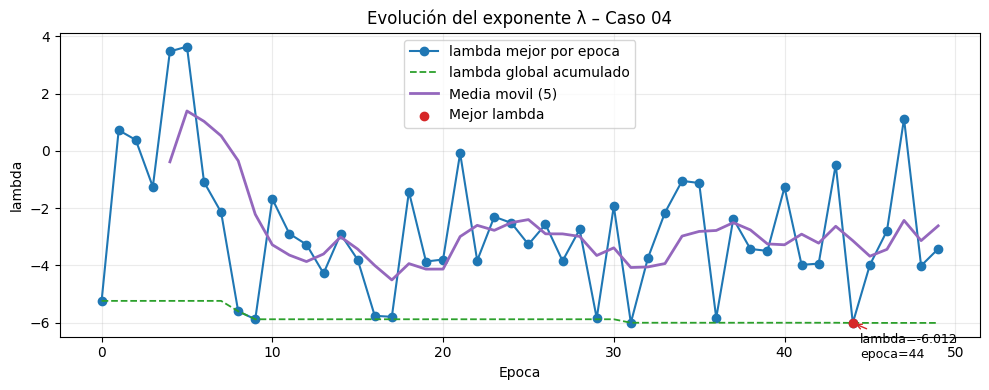

In [14]:
viz_3d = Visualizer3D(headless=cfg.headless)

_ = viz_3d.plot_lambda_evolution(
    lambda_history=metrics.best_lambda_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolución del exponente λ – Caso 04",
    moving_average_window=5,   # opcional
)

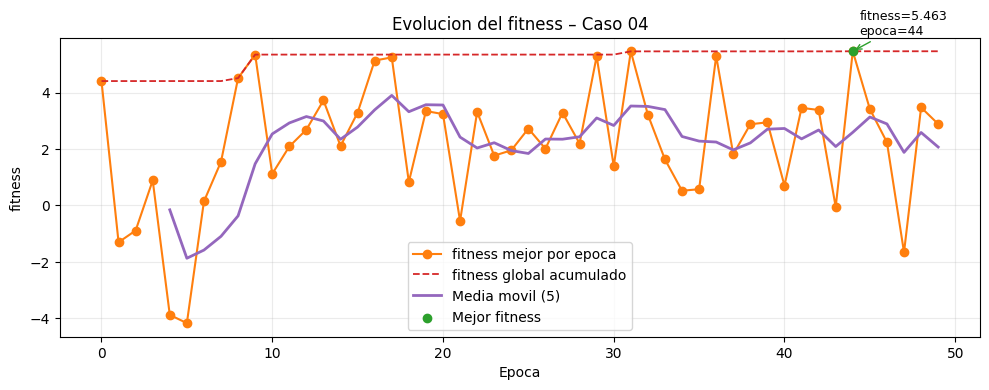

In [15]:
_ = viz_3d.plot_fitness_evolution(
    fitness_history=metrics.best_fitness_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolucion del fitness – Caso 04",
    moving_average_window=5,
)


In [16]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
print("Trayectoria calculada con masas óptimas.")
print(traj.shape)
print(traj[-1])
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]


Trayectoria calculada con masas óptimas.
(17500, 3, 6)
[[ 0.37714083 -0.10369043  0.          0.91793287 -1.15881464  0.        ]
 [-1.01846405  0.16785092  0.         -0.56286727 -4.67812295  0.        ]
 [ 0.38379472  0.15407259  0.         -3.50026983 16.89042955  0.        ]]


In [17]:
from two_body.scripts.demo_tierra import (
    summarize_trajectory,
    compute_total_energy,
    estimate_orbital_period,
)

summarize_trajectory(
    logger=logger,
    traj=traj,
    masses=best_masses,
    cfg=cfg,
)

[2025-11-02 18:26:01,866] INFO - Resumen de simulacion
[2025-11-02 18:26:01,866] INFO -   pasos=17500 | dt=0.000200 anos | duracion total=3.500 anos
[2025-11-02 18:26:01,866] INFO -   masas=(1.3737238714189304, 0.6076306072941796, 0.2625428800333757) (M_sun) | G=39.478418
[2025-11-02 18:26:01,867] INFO -   centro de masa: desplazamiento maximo = 5.559e-14 UA
[2025-11-02 18:26:01,868] INFO -   cuerpo 0 -> radio[min, max]=[0.0903, 0.5236] UA | radio sigma=1.0422e-01 | velocidad media=2.8624 UA/ano
[2025-11-02 18:26:01,869] INFO -   cuerpo 1 -> radio[min, max]=[0.2301, 1.3093] UA | radio sigma=2.5661e-01 | velocidad media=6.2407 UA/ano
[2025-11-02 18:26:01,870] INFO -   cuerpo 2 -> radio[min, max]=[0.0315, 1.6115] UA | radio sigma=3.3721e-01 | velocidad media=7.4889 UA/ano
[2025-11-02 18:26:01,873] INFO -   energia total (media)=-3.558373e+01 | variacion relativa=6.651e-09
[2025-11-02 18:26:01,874] INFO -   periodo orbital estimado para la Tierra ~= 0.345634 anos
[2025-11-02 18:26:01,874]

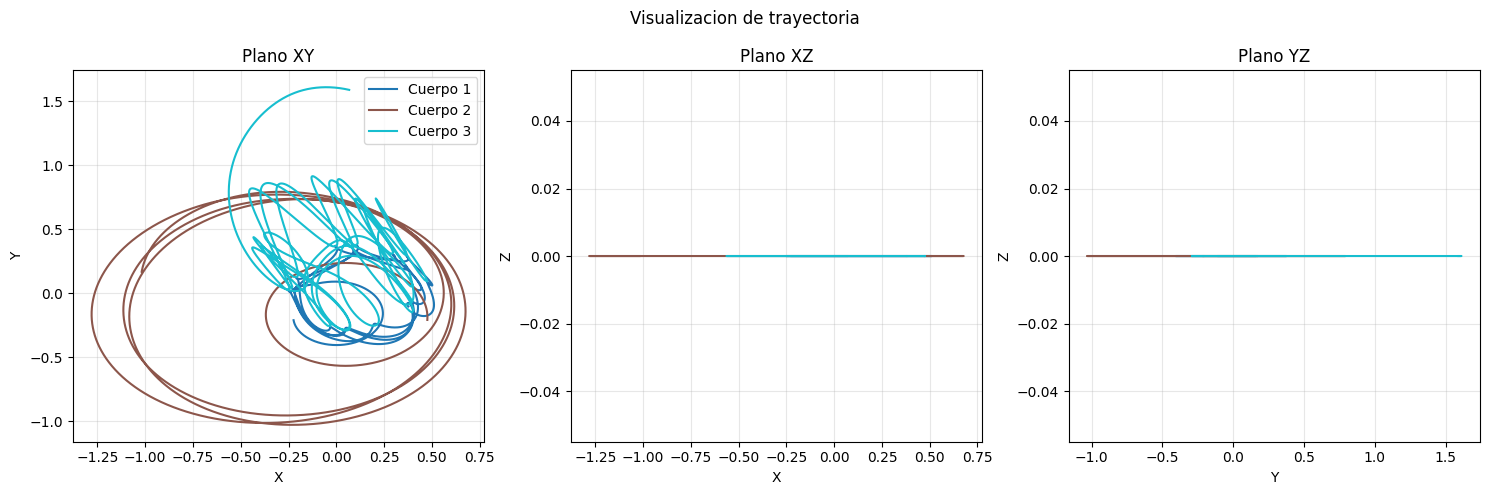

In [18]:
viz_planar = PlanarVisualizer(headless=cfg.headless)
_ = viz_planar.quick_view(xyz_tracks)  # usa una asignación para que Jupyter no duplique la figura

In [19]:
from IPython.display import HTML

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50  # MB

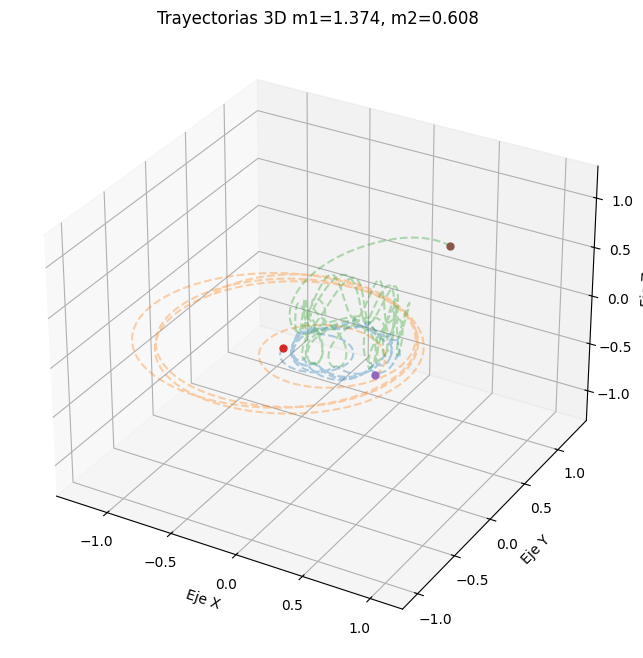

In [20]:
viz_3d = Visualizer3D(headless=False)

anim = viz_3d.animate_3d(
    trajectories=xyz_tracks,
    interval_ms=50,
    title=f"Trayectorias 3D m1={best_masses[0]:.3f}, m2={best_masses[1]:.3f}",
    total_frames=len(xyz_tracks[0]),
)
#HTML(anim.to_jshtml())  

## Exportación de animaciones

Preparamos un `FFMpegWriter`, creamos `artifacts/caso04` y guardamos los MP4 tanto de la órbita como de la comparación de masas. Ajusta `fps`, `bitrate` o `dpi` si necesitas equilibrar rapidez y calidad de render.


In [21]:
from matplotlib.animation import FFMpegWriter  # o PillowWriter para GIF

writer = FFMpegWriter(
    fps=20,
    bitrate=1800,
    extra_args=["-vcodec", "libx264", "-preset", "ultrafast", "-crf", "28"],
)
output_path = Path("artifacts/caso04")                # ajusta a tu gusto
output_path.mkdir(parents=True, exist_ok=True)

anim.save(output_path / "trayectoria_optima.mp4", writer=writer)


In [ ]:
sim_orig = sim_builder.setup_simulation(center, r0, v0)
traj_original = sim_builder.integrate(sim_orig, t_end=cfg.t_end_long, dt=cfg.dt)

traj_opt = traj

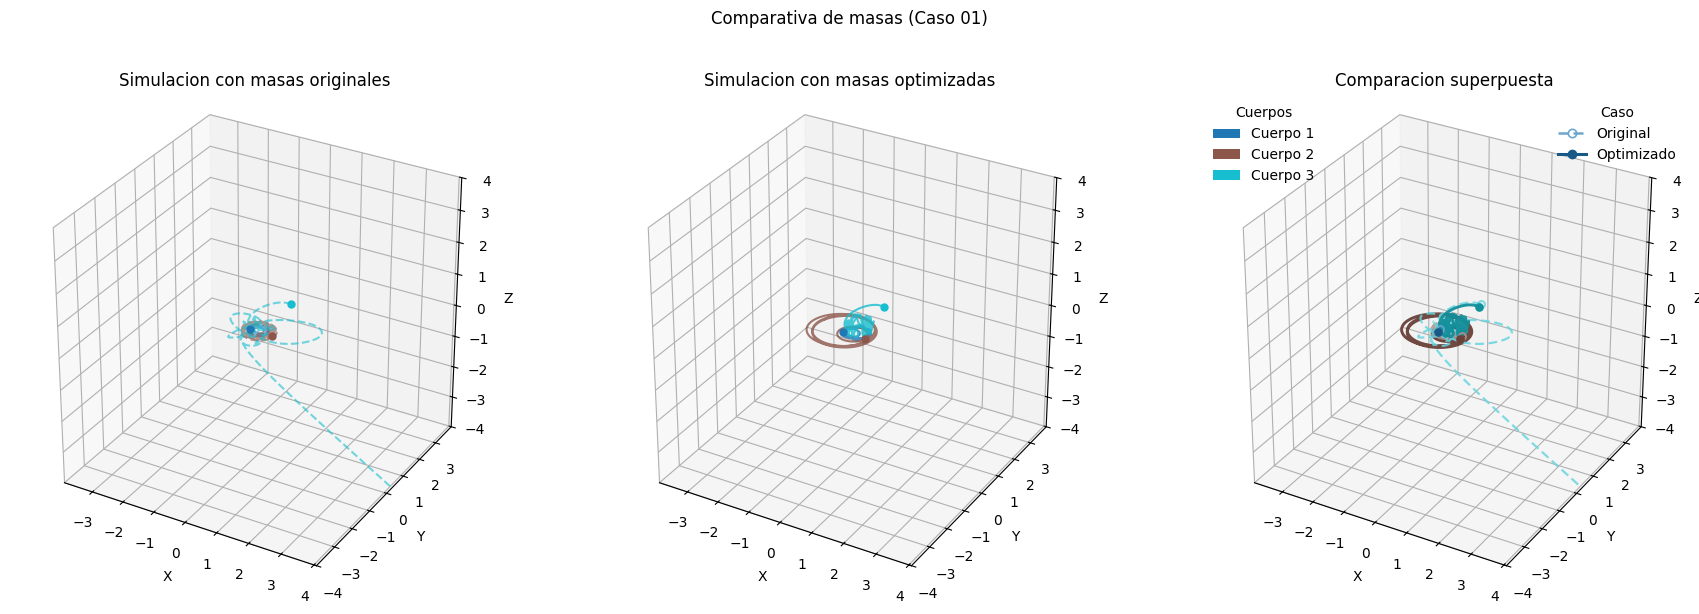

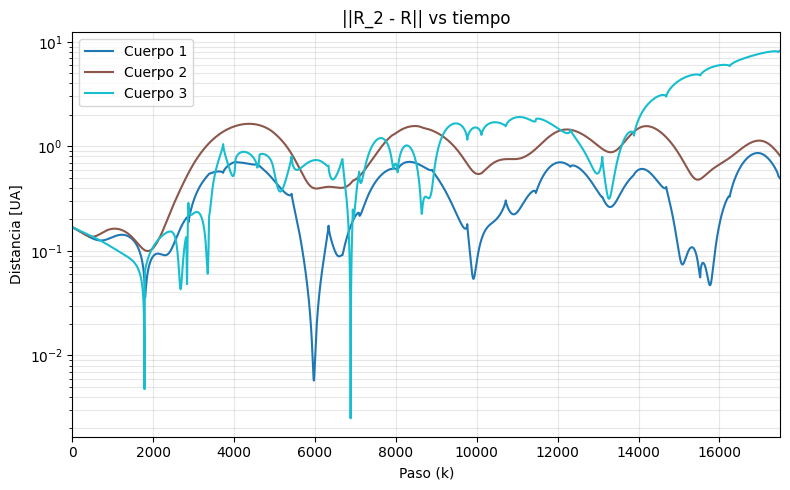

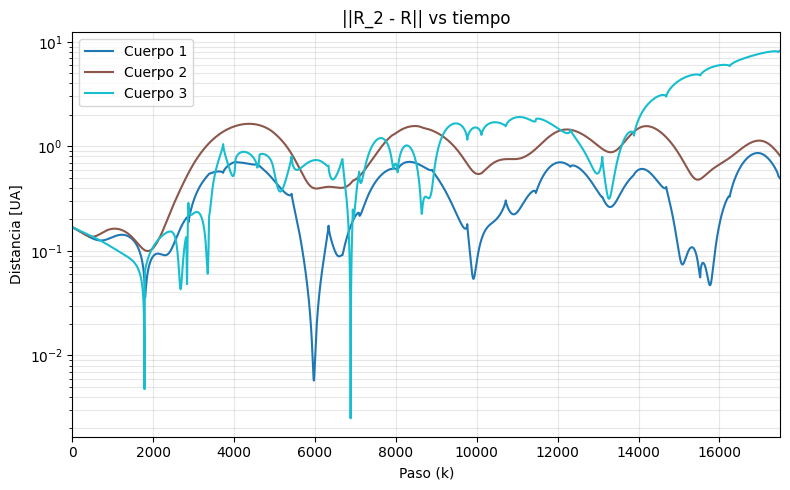

In [ ]:
orig_tracks = [traj_original[:, i, :3] for i in range(traj_original.shape[1])]
opt_tracks = [traj_opt[:, i, :3] for i in range(traj_opt.shape[1])]

anim_mass = viz_3d.plot_mass_comparison(
    original_tracks=orig_tracks,
    optimized_tracks=opt_tracks,
    original_masses=center,    
    optimized_masses=best_masses,
    body_labels=[f"Cuerpo {i+1}" for i in range(len(opt_tracks))],
    dt=cfg.dt,
    title="Comparativa de masas (Caso 01)",
)

if anim_mass is not None:
    dist_fig = viz_3d.plot_mass_distance_evolution(
        comparison_data=anim_mass.mass_comparison_data,
        title="||R_2 - R|| vs tiempo",
    )
    if dist_fig is not None:
        display(dist_fig)
    # display(HTML(anim_mass.to_jshtml()))  # descomenta para ver la animación embebida


In [24]:
anim_mass.save(output_path / "comparativa_masas.mp4", writer=writer)

## Reporte de tiempos

Leemos el CSV más reciente de la instrumentación, mostramos una muestra y agrupamos por sección para identificar los cuellos de botella (por ejemplo, integración larga con tres cuerpos no colineales).


In [25]:
import pandas as pd

csv_path = latest_timing_csv()
display(f"Usando CSV: {csv_path}")

rows = read_timings_csv(csv_path)
df = pd.DataFrame(rows)
display(df.head(10))

# Estadísticas rápidas por sección
section_stats = (
    df.groupby("section")["duration_us"]
    .agg(["count", "mean", "sum"])
    .sort_values("sum", ascending=False)
)
section_stats

'Usando CSV: C:\\Users\\emicr\\Documents\\CODIGOS_FUENTES\\TrabajoTerminal\\collision_of_two_bodies\\two_body\\data\\timings\\timings_ddf0b833-a5c4-4572-b8c0-19a388d2f328_20251103_000322.csv'

,run_id,epoch,batch_id,individual_id,section,start_ns,end_ns,duration_us,extra
0,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689749600,19529689791500,41,"{'step': 0, 'dt': 0.0002, 't_target': 0.0002}"
1,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689823000,19529689841300,18,"{'step': 1, 'dt': 0.0002, 't_target': 0.0004}"
2,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689854900,19529689868200,13,"{'step': 2, 'dt': 0.0002, 't_target': 0.000600..."
3,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689878500,19529689890900,12,"{'step': 3, 'dt': 0.0002, 't_target': 0.0008}"
4,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689898600,19529689910900,12,"{'step': 4, 'dt': 0.0002, 't_target': 0.001}"
5,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689918600,19529689931400,12,"{'step': 5, 'dt': 0.0002, 't_target': 0.001200..."
6,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689938900,19529689951000,12,"{'step': 6, 'dt': 0.0002, 't_target': 0.0014}"
7,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689958000,19529689971200,13,"{'step': 7, 'dt': 0.0002, 't_target': 0.0016}"
8,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689977700,19529689989400,11,"{'step': 8, 'dt': 0.0002, 't_target': 0.001800..."
9,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689996600,19529690008400,11,"{'step': 9, 'dt': 0.0002, 't_target': 0.002}"


,count,mean,sum
section,,,
notebook_run,1,1.096908e+09,1096907618
batch_eval,101,1.083186e+07,1094018184
fitness_eval,9601,1.139131e+05,1093680126
lyapunov_compute,9593,1.137711e+05,1091406360
simulation_step,34559992,1.975024e+01,682568261
ga_main,50,5.628382e+04,2814191
crossover,1170,6.534650e+02,764554
selection_tournament,1170,2.775957e+02,324787
mutation,1170,1.874342e+02,219298


In [ ]:
import os
import subprocess
from pathlib import Path
from IPython.display import Image, display

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

env = os.environ.copy()
env["PYTHONPATH"] = str(PROJECT_ROOT)

run_id = df["run_id"].iloc[0]
cmd = [
    sys.executable,
    "scripts/plot_timings.py",
    "--run-id", str(run_id),
    "--top-n", "5",
]


print("Ejecutando:", " ".join(cmd))
result = subprocess.run(cmd, cwd=PROJECT_ROOT, env=env, text=True, capture_output=True)
print(result.stdout)
print(result.stderr)
result.check_returncode()

reports_dir = PROJECT_ROOT / "reports"

display(
    Image(filename=str(reports_dir / f"timeline_by_individual_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_by_batch_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_simulation_{run_id}.png")),
    Image(filename=str(reports_dir / f"pie_sections_{run_id}.png")),
)


Ejecutando: c:\Users\emicr\anaconda3\envs\grav2body\python.exe scripts/plot_timings.py --run-id ddf0b833-a5c4-4572-b8c0-19a388d2f328 --top-n 5


In [ ]:
# from pathlib import Path
# 
# 
# output_path = Path("artifacts/animations/caso01_orbit.gif")
# output_path2 = Path("artifacts/animations/caso01_comparasion.gif")
# output_path.parent.mkdir(parents=True, exist_ok=True)
# 
# anim.save(
#     output_path,
#     writer="pillow",
#     fps=20,
#     dpi=100,          # opcional
# )
# 
# print(f"Animación 3D guardada en {output_path}")
# 